# Flagging

Demonstration of prototype ngCASA flagging functions. This is work in progress.

This walkthrough is designed to be run in a Jupyter notebook on Google Colaboratory. To open the notebook in colab, go [here](https://colab.research.google.com/github/FedeMPouzols/cngi_prototype/blob/ngcasa_flagging_experiments/docs/flagging.ipynb)



## Get required packages and data

In [ ]:
# TEMPORARY WORKAROUND for Python 3.7 - you must run this notebook twice!!
import os
import numpy as np

if np.__version__ != '1.20.1':
    print('updating numpy and killing runtime....\nPlease re-run this notebook (Runtime -> Run all)')
    os.system('pip install --upgrade numpy==1.20.1')
    os._exit(00)

updating numpy and killing runtime....
Please re-run this notebook (Runtime -> Run all)


In [1]:
# Installation
import os
# (WIP note: we might get by without casatools, if we prepare some .vis.zarr available for download re-check)
print("installing casa6 + cngi (takes a minute or two)...")
!apt-get install libgfortran3

!pip install --index-url https://casa-pip.nrao.edu:443/repository/pypi-group/simple casatasks==6.2.0.96
!pip install --index-url https://casa-pip.nrao.edu:443/repository/pypi-group/simple casadata
!pip install --extra-index-url https://test.pypi.org/simple/ cngi-prototype==0.0.75

installing casa6 + cngi (takes a minute or two)...
/bin/bash: apt-get: command not found
Looking in indexes: https://casa-pip.nrao.edu:443/repository/pypi-group/simple
Looking in indexes: https://casa-pip.nrao.edu:443/repository/pypi-group/simple
Looking in indexes: https://pypi.org/simple, https://test.pypi.org/simple/


In [2]:
# Retrieve and extract demonstration datasets
print('retrieving MS tarfiles...')
!gdown -q --id 15HfB4rJKqEH7df088Ge5YLrCTXBIax6R
print('extracting MS tarfiles...')
!tar -xzf sis14_twhya_calibrated_flagged.ms.tar.gz
print('complete')

retrieving MS tarfiles...
extracting MS tarfiles...
complete


## Initialize the Environment
Omitting for now. I think we don't need it here and it shouldn't show up here at the ngCASA level anyway.

## Load demo data

In [3]:
from cngi.conversion import convert_ms

zarr_name = 'twhya.vis.zarr' 
mxds = convert_ms('sis14_twhya_calibrated_flagged.ms', outfile=zarr_name) 

Completed ddi 0  process time 11.28 smaining time est 0 s                           
Completed subtables  process time 0.94 sSTATION_POSITION...                     
                                                  


In [4]:
from cngi.dio import describe_vis 
# We will be working with the only SPW (xds0) present in this dataset, for simplicity
describe_vis(zarr_name)

,spw_id,pol_id,times,baselines,chans,pols,size_MB
xds,,,,,,,
xds0,0,0,410,210,384,2,1586


## Flag summaries
Summaries of flags by different dimensions in a dictionary, similar to the dictionary produce by CASA flagdata in 'summary' mode.

In [5]:
from ngcasa.flagging import summary
# <temporary> prepare for summaries
mxds.xds0['presence_baseline'] = mxds.xds0.DATA.notnull().any(['chan', 'pol'])
# </temporary>
# Get the initial flagging status
counts = summary(mxds, 0)
counts

{'correlation': {'XX': {'flagged': 22800, 'total': 30936192},
  'YY': {'flagged': 22800, 'total': 30936192}},
 'total': 61872384,
 'flagged': 45600,
 'array': {'0': {'flagged': 45600, 'total': 61872384}},
 'scan': {'4': {'flagged': 0, 'total': 3225600},
  '7': {'flagged': 45600, 'total': 2918400},
  '10': {'flagged': 0, 'total': 1459200},
  '12': {'flagged': 0, 'total': 6538752},
  '14': {'flagged': 0, 'total': 1459200},
  '16': {'flagged': 0, 'total': 7956480},
  '18': {'flagged': 0, 'total': 1612800},
  '20': {'flagged': 0, 'total': 7926528},
  '22': {'flagged': 0, 'total': 1612800},
  '24': {'flagged': 0, 'total': 7928832},
  '26': {'flagged': 0, 'total': 1612800},
  '28': {'flagged': 0, 'total': 7266816},
  '30': {'flagged': 0, 'total': 1459200},
  '33': {'flagged': 0, 'total': 2612736},
  '34': {'flagged': 0, 'total': 1459200},
  '36': {'flagged': 0, 'total': 3210240},
  '38': {'flagged': 0, 'total': 1612800}},
 'observation': {'0': {'flagged': 45600, 'total': 61872384}},
 'field'

## Handling flag versions




In [6]:
from ngcasa.flagging import manager_list, manager_add, manager_remove
print('* Printing list of flag variables - checkpoint 0:')
versions = manager_list(mxds.xds0)
print(versions)

vis_flags = manager_add(mxds.xds0, 'FLAG_START', 'flags state at start')
# vis_flags = manual_unflag(vis_flags, [{'time': slice('2011-09-16T15:38:17','2011-10-16T18:39:50')}])
vis_flags = manager_add(vis_flags, 'FLAG_BACKUP', 'backup description')
#
vis_flags = manager_add(vis_flags, 'FLAG_FINAL', 'backup second descr')
#
print('* Printing list - checkpoint A:')
versions = manager_list(vis_flags)
print(versions)

# fxds['FLAG'] = fxds['FLAG_final']
vis_flags['FLAG'] = vis_flags['FLAG_BACKUP'] | vis_flags['FLAG_START']

# We can always drop versions that are no longer useful
vis_flags = manager_remove(vis_flags, 'FLAG_START')
vis_flags = manager_remove(vis_flags, 'FLAG_BACKUP')
vis_flags = manager_remove(vis_flags, 'FLAG_FINAL')
print('* Printing list - checkpoint B:')
versions = manager_list(vis_flags)
print(versions)
# FLAG variables as added as regular data variables in the xarray Datasets
# An aditional attribute (flag_variables) are added for bookkeeping
vis_flags

* Printing list of flag variables - checkpoint 0:
  Flag variable name             Description
0               FLAG  Default flags variable
* Printing list - checkpoint A:
  Flag variable name             Description
0               FLAG  Default flags variable
1         FLAG_START    flags state at start
2        FLAG_BACKUP      backup description
3         FLAG_FINAL     backup second descr
* Printing list - checkpoint B:
  Flag variable name             Description
0               FLAG  Default flags variable


<xarray.Dataset>
Dimensions:            (baseline: 210, chan: 384, pol: 2, pol_id: 1, spw_id: 1, time: 410, uvw_index: 3)
Coordinates:
  * baseline           (baseline) int64 0 1 2 3 4 5 ... 204 205 206 207 208 209
  * chan               (chan) float64 3.725e+11 3.725e+11 ... 3.728e+11
    chan_width         (chan) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    effective_bw       (chan) float64 dask.array<chunksize=(32,), meta=np.ndarray>
  * pol                (pol) int64 9 12
  * pol_id             (pol_id) int64 0
    resolution         (chan) float64 dask.array<chunksize=(32,), meta=np.ndarray>
  * spw_id             (spw_id) int64 0
  * time               (time) datetime64[ns] 2012-11-19T07:37:00 ... 2012-11-...
Dimensions without coordinates: uvw_index
Data variables:
    ANTENNA1           (baseline) int64 dask.array<chunksize=(210,), meta=np.ndarray>
    ANTENNA2           (baseline) int64 dask.array<chunksize=(210,), meta=np.ndarray>
    ARRAY_ID           (time, baseline) int64 dask.array<chunksize=(100, 210), meta=np.ndarray>
    DATA               (time, baseline, chan, pol) complex128 dask.array<chunksize=(100, 210, 32, 1), meta=np.ndarray>
    DATA_WEIGHT        (time, baseline, chan, pol) float64 dask.array<chunksize=(100, 210, 32, 1), meta=np.ndarray>
    EXPOSURE           (time, baseline) float64 dask.array<chunksize=(100, 210), meta=np.ndarray>
    FEED1              (time, baseline) int64 dask.array<chunksize=(100, 210), meta=np.ndarray>
    FEED2              (time, baseline) int64 dask.array<chunksize=(100, 210), meta=np.ndarray>
    FIELD_ID           (time, baseline) int64 dask.array<chunksize=(100, 210), meta=np.ndarray>
    FLAG               (time, baseline, chan, pol) bool dask.array<chunksize=(100, 210, 32, 1), meta=np.ndarray>
    INTERVAL           (time, baseline) float64 dask.array<chunksize=(100, 210), meta=np.ndarray>
    OBSERVATION_ID     (time, baseline) int64 dask.array<chunksize=(100, 210), meta=np.ndarray>
    PROCESSOR_ID       (time, baseline) int64 dask.array<chunksize=(100, 210), meta=np.ndarray>
    SCAN_NUMBER        (time, baseline) int64 dask.array<chunksize=(100, 210), meta=np.ndarray>
    STATE_ID           (time, baseline) int64 dask.array<chunksize=(100, 210), meta=np.ndarray>
    TIME_CENTROID      (time, baseline) float64 dask.array<chunksize=(100, 210), meta=np.ndarray>
    UVW                (time, baseline, uvw_index) float64 dask.array<chunksize=(100, 210, 3), meta=np.ndarray>
    presence_baseline  (time, baseline) bool dask.array<chunksize=(100, 210), meta=np.ndarray>
    FLAG_START         (time, baseline, chan, pol) bool dask.array<chunksize=(100, 210, 32, 1), meta=np.ndarray>
    FLAG_BACKUP        (time, baseline, chan, pol) bool dask.array<chunksize=(100, 210, 32, 1), meta=np.ndarray>
    FLAG_FINAL         (time, baseline, chan, pol) bool dask.array<chunksize=(100, 210, 32, 1), meta=np.ndarray>
Attributes:
    assoc_nature:     ['', '', '', '', '', '', '', '', '', '', '', '', '', ''...
    bbc_no:           2
    corr_product:     [[0, 0], [1, 1]]
    data_groups:      [{'0': {'data': 'DATA', 'flag': 'FLAG', 'id': '0', 'uvw...
    freq_group:       0
    freq_group_name:  
    if_conv_chain:    0
    meas_freq_ref:    5
    name:             ALMA_RB_07#BB_2#SW-01#FULL_RES
    net_sideband:     2
    num_chan:         384
    num_corr:         2
    ref_frequency:    372533086425.9812
    total_bandwidth:  234375000.0
    flag_variables:   {'FLAG': 'Default flags variable'}

## Running flagging methods
A few illustrative examples, trying to cover all the categories of flagging methods.



### Manual flagging and meta-information based methods
Methods based on data selection and/or meta-information. Simple examples with data selection based flagging and unflagging.

In [7]:
from ngcasa.flagging import manual_flag, manual_unflag

vis_dset = manager_add(mxds.xds0, 'FLAG_CHECKPOINT_A', 'after a couple of example manual selections')
#
vis_dset = manager_add(vis_dset, 'FLAG_MANUAL_SELS', 'after applying a few manual flags')

# unflag one antenna (not present)
vis_partial = manual_unflag(mxds, 0, [{'antenna': 'DV01'}])
# unflag one antenna (present)
vis_partial = manual_unflag(mxds, 0, [{'antenna': 'DV02'}])
# unflag all
vis_unflagged = manual_unflag(mxds, 0, [])
# <tmp> Handle return xds / mxds(use cngi._utils._io.vis_xds_packager?)
mxds_manual = mxds
mxds_manual.xds0['FLAG'] = vis_unflagged['FLAG']
# </tmp>
counts = summary(mxds_manual, 0)
print('* Flags after unflagging:')
counts

 *** Going for cmd: {'antenna': 'DV01'}, selection: {'baseline': array([], dtype=int64)}
 *** Going for cmd: {'antenna': 'DV02'}, selection: {'baseline': array([119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
         6,  25,  43,  60,  76,  91, 105])}
* Flags after unflagging:


{'correlation': {'XX': {'flagged': 0, 'total': 30936192},
  'YY': {'flagged': 0, 'total': 30936192}},
 'total': 61872384,
 'flagged': 0,
 'array': {'0': {'flagged': 0, 'total': 61872384}},
 'scan': {'4': {'flagged': 0, 'total': 3225600},
  '7': {'flagged': 0, 'total': 2918400},
  '10': {'flagged': 0, 'total': 1459200},
  '12': {'flagged': 0, 'total': 6538752},
  '14': {'flagged': 0, 'total': 1459200},
  '16': {'flagged': 0, 'total': 7956480},
  '18': {'flagged': 0, 'total': 1612800},
  '20': {'flagged': 0, 'total': 7926528},
  '22': {'flagged': 0, 'total': 1612800},
  '24': {'flagged': 0, 'total': 7928832},
  '26': {'flagged': 0, 'total': 1612800},
  '28': {'flagged': 0, 'total': 7266816},
  '30': {'flagged': 0, 'total': 1459200},
  '33': {'flagged': 0, 'total': 2612736},
  '34': {'flagged': 0, 'total': 1459200},
  '36': {'flagged': 0, 'total': 3210240},
  '38': {'flagged': 0, 'total': 1612800}},
 'observation': {'0': {'flagged': 0, 'total': 61872384}},
 'field': {'J0522-364': {'flagge

### Manual flagging with command lists
An example of application of a list of manual flagging commands, resembling use cases from pipelines. An additional required input is the file of flagging commands. Here we use a `.flagonline.txt` file as used in pipelines, where we usually find of the order of 1000s or 10s of thousands of commands. The `.flagonline.txt` is the lion's share of the full list of commands used by pipelines (`.flagcmds.txt`), where the `.flagonline.txt` list of commands is extended with a much shorter list of additional commands that may include a number of summaries, selections based on intent and frequency, the shadow method, etc.

The selection syntax used is the Xarray selection syntax (see examples in the [Visibilities walkthrough ](visibilities.ipynb)), with selection by label `xds.sel(...)`.

In [8]:
vis_flags = manual_unflag(mxds, 0, [{'time': slice('2011-09-16T15:38:17','2011-10-16T18:39:50')}])
#
vis_flags = manual_unflag(mxds, 0, [{}])

# Flag two groups of adjacent ~20 chans
vis_flags = manual_flag(mxds, 0, [{'chan': slice(3.7266e11, 3.7271e11)}, 
                                  {'chan': slice(3.7276e9, 3.728e11)}])

# Flag some baselines, by ID
vis_flags = manual_flag(mxds, 0, [{'baseline': [133, 134, 135]}])
# Flag polarization, by ID
vis_flgs = manual_flag(mxds, 0, [{'pol': 9}])

# vis_dset = manual_flag(vis_dset, cmdfile='.flagonline.txt')
vis_flags = manager_add(vis_flags, 'FLAG_MANUAL_LIST', 'after applying list of selection commands')


# <tmp> Handle return xds / mxds(use cngi._utils._io.vis_xds_packager?)
mxds.xds0['FLAG'] = vis_flags['FLAG']
# </tmp>
print('* Printing list - after flagging:')
versions = manager_list(vis_flags)
print(versions)

# vis_flags = manual_flag(mxds, 0, cmd_filename='short_twhya.flagonline.txt')

print('* Flags after flagging some channels and baselines:')
counts = summary(mxds, 0)
print(counts)

 *** Going for cmd: {'time': slice('2011-09-16T15:38:17', '2011-10-16T18:39:50', None)}, selection: {'time': slice(numpy.datetime64('2011-09-16T15:38:17'), numpy.datetime64('2011-10-16T18:39:50'), None)}
 *** Going for cmd: {}, selection: {}
 *** Going for cmd: {'chan': slice(372660000000.0, 372710000000.0, None)}, selection: {'chan': slice(372660000000.0, 372710000000.0, None)}
 *** Going for cmd: {'chan': slice(3727600000.0, 372800000000.0, None)}, selection: {'chan': slice(3727600000.0, 372800000000.0, None)}
 *** Going for cmd: {'baseline': [133, 134, 135]}, selection: {}
 *** Going for cmd: {'pol': 9}, selection: {'pol': 9}
* Printing list - after flagging:
  Flag variable name                                  Description
0               FLAG                       Default flags variable
1  FLAG_CHECKPOINT_A  after a couple of example manual selections
2   FLAG_MANUAL_SELS            after applying a few manual flags
3   FLAG_MANUAL_LIST    after applying list of selection commands

### Auto-flagging methods
An illustrative example using the `auto_clip` method. Other auto-flagging methods such as tfcrop, rflag, and uvbin are not implemented.

In [10]:
from ngcasa.flagging import auto_clip
# 
# vis_dset = manager_add(vis_dset, 'auto_clip_test1', 'after applying clip')
versions = manager_list(vis_dset)
print(versions)

vis_clip = auto_clip(vis_dset, 10, 35)
# <tmp> Handle return xds / mxds (use cngi._utils._io.vis_xds_packager?)
mxds.xds0['FLAG'] = vis_clip['FLAG']
# </tmp>
counts_clip = summary(mxds, 0)
print(counts_clip)

  Flag variable name                                  Description
0               FLAG                       Default flags variable
1  FLAG_CHECKPOINT_A  after a couple of example manual selections
2   FLAG_MANUAL_SELS            after applying a few manual flags
3   FLAG_MANUAL_LIST    after applying list of selection commands
{'correlation': {'XX': {'flagged': 15761725, 'total': 30936192}, 'YY': {'flagged': 20308487, 'total': 30936192}}, 'total': 61872384, 'flagged': 36070212, 'array': {'0': {'flagged': 36070212, 'total': 61872384}}, 'scan': {'4': {'flagged': 1503426, 'total': 3225600}, '7': {'flagged': 1375898, 'total': 2918400}, '10': {'flagged': 856645, 'total': 1459200}, '12': {'flagged': 3588925, 'total': 6538752}, '14': {'flagged': 896040, 'total': 1459200}, '16': {'flagged': 4885157, 'total': 7956480}, '18': {'flagged': 1042825, 'total': 1612800}, '20': {'flagged': 4699547, 'total': 7926528}, '22': {'flagged': 1051648, 'total': 1612800}, '24': {'flagged': 4921773, 'total': 792

## Applying flags
To apply a version of flags on a visibilities dataset, before going on to further processing, the function `cngi.vis.apply_flags` should be applied. Some examples can be found in the [Continuum Imaging Example](imaging/continuum_imaging_example.ipynb) or the [Visibilities walkthrough](visibilities.ipynb). `cngi.vis.apply_flags` sets the flagged data values to NaN. This has the effect that those NaN values are effectively excluded from subsequent CNGI/ngCASA processing. Other components of CNGI and ngCASA, such as imaging, will ignore those NaN values.

* versions of flags:   Flag variable name                                  Description
0               FLAG                       Default flags variable
1  FLAG_CHECKPOINT_A  after a couple of example manual selections
2   FLAG_MANUAL_SELS            after applying a few manual flags
3   FLAG_MANUAL_LIST    after applying list of selection commands


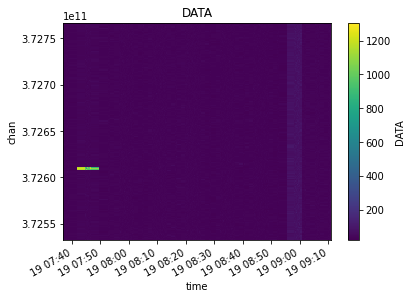

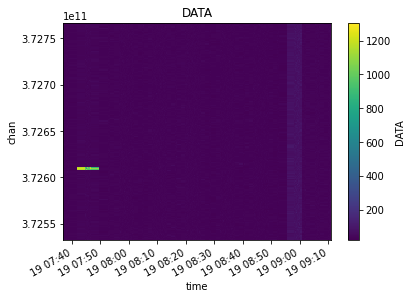

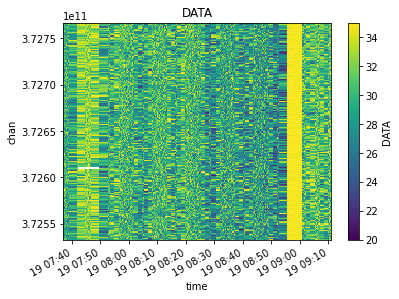

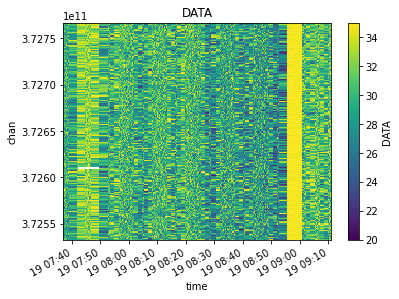

In [14]:
# Further processing: visualization, calibration, imaging, etc. with flags applied (flagged data excluded)
# ...
from cngi.vis import apply_flags
from cngi.vis import visplot
from cngi._utils._io import mxds_copier

versions = manager_list(vis_dset)
print(f"* versions of flags: {versions}")
plot_axes = ['time', 'chan']

mxds_manual = mxds.copy()
mxds_manual.attrs['xds0'] = vis_dset
flagged_manual = apply_flags(mxds_manual, 'xds0', flags=['FLAG_MANUAL_SELS'])
visplot(flagged_manual.xds0.DATA, plot_axes)
visplot(mxds.xds0.DATA, plot_axes)

mxds_flagged = apply_flags(mxds, 'xds0', flags=['FLAG'])
visplot(mxds_flagged.xds0.DATA, plot_axes)

mxds_clip = mxds.copy()
mxds_clip.attrs['xds0'] = vis_clip
flagged_clip = apply_flags(mxds, 'xds0', flags=['FLAG'])
visplot(flagged_clip.xds0.DATA, plot_axes)

#flagged_clip = apply_flags(mxds, 'xds0', flags=['FLAG_AUTO_CLIP'])
#visplot(flagged_clip.DATA, plot_coords)